Do not merge cells. Each cell need to be executed on their own and wait for UI to update the diagram.

In [2]:
# if you see a timeout error, please restart the kernel and run again.
import cx_fbl.cx_lib as cxlib
import itertools
import networkx as nx
cx = cxlib.CX_Constructor(nm[0], 'Givon_frontiers17')

[FFBOLab Client NLP 2019-03-30 07:47:05] Received a message.
[FFBOLab Client NLP 2019-03-30 07:47:10] Received a message.
[FFBOLab Client NLP 2019-03-30 07:47:12] Received a message.


In [4]:
# These can be performed by clicking on corresponding items, too.
cx.disable_neurons(['PB/R3/s-EB/3/b-lal/LDG/b', 'PB/L1/s-FB/(2,R[2-3])/s-LAL/RHB/b'])
# cx.disable_synapses([...])
# cx.disable_subregions([...])

In [6]:
# remove disabled components from the database query
res = cx.remove_components()

[FFBOLab Client NLP 2019-03-30 07:47:55] Received a message.
[FFBOLab Client NLP 2019-03-30 07:48:15] Received a message.


In [7]:
# Now I want to use an InputProcessor called StepInputProcessor to inject current
# to a PB-EB-LAL neuron that innervates PB/R5 and PB/L3.

# We first find uid of this PB-EB-LAL neuron.
uids = []
uids.extend(cx.neuron_uid_by_family('PB-EB-LAL', 'PB/R5'))
uids.extend(cx.neuron_uid_by_family('PB-EB-LAL', 'PB/L3'))

# Since the PB-EB-LAL neuron is a PB neuron, it will be executed in the PB LPU.
# So we first create an entry for PB in the input_processors dict,
# with name "StepInputProcessor". All the parameters should be spelt out in the dict.
# Additional input processors can be specified by extending the list.
input_processors = {'PB': [{'name': 'StepInputProcessor', 'variable': 'I', 'uids': uids,
                           'val': 40.0, 'start': 0.1, 'stop': 0.9}]}


In [8]:
cx.execute(input_processors = input_processors, steps = 10000, dt = 1e-4)

[FFBOLab Client NLP 2019-03-30 07:48:38] Received a message.
{'nlp': {'7545757007346388': {'name': 'nlp_server'}}, 'nk': {'2780491976549839': {'name': 'nk_server'}}, 'na': {'4256731523135016': {'name': 'na_server_with_vfb_links'}}}
[FFBOLab Client NLP 2019-03-30 07:48:59] Received a message.
Execution request sent. Please wait.
[FFBOLab Client NLP 2019-03-30 07:50:03] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:05] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:06] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:07] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:08] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:10] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:11] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:12] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:13] Received partial data.
[FFBOLab Client NLP 2019-03-30 07:50:15] Received partial data.
[FFBOLab Client NLP 2019-03-30

In [9]:
B, neurons = cx.get_result()

Shape of Results: (346, 1000)


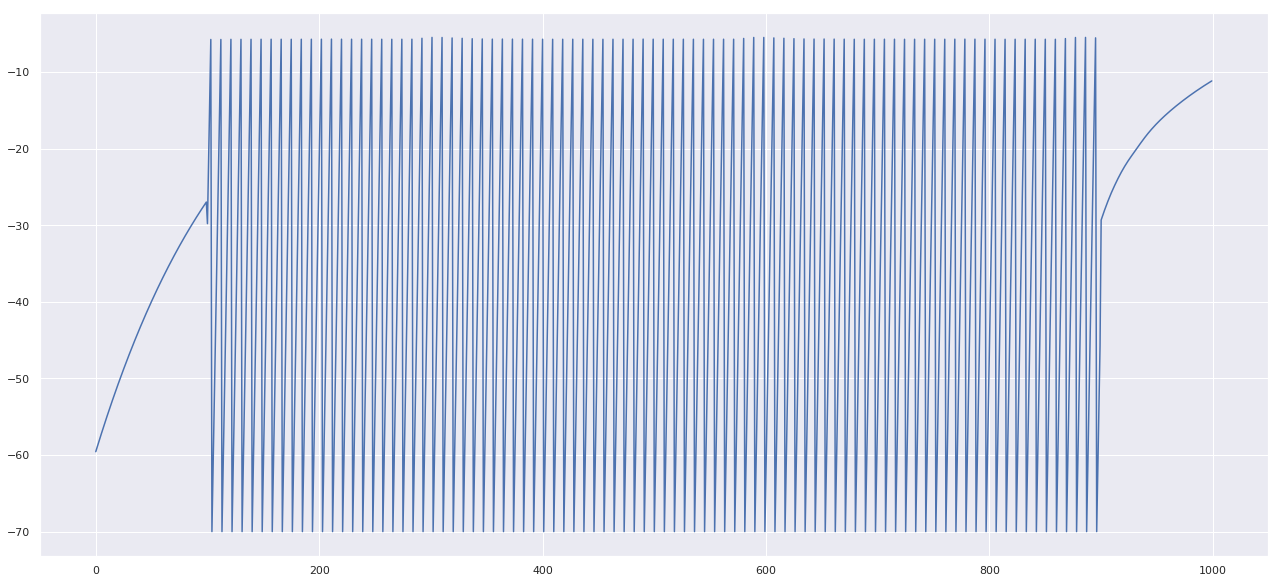

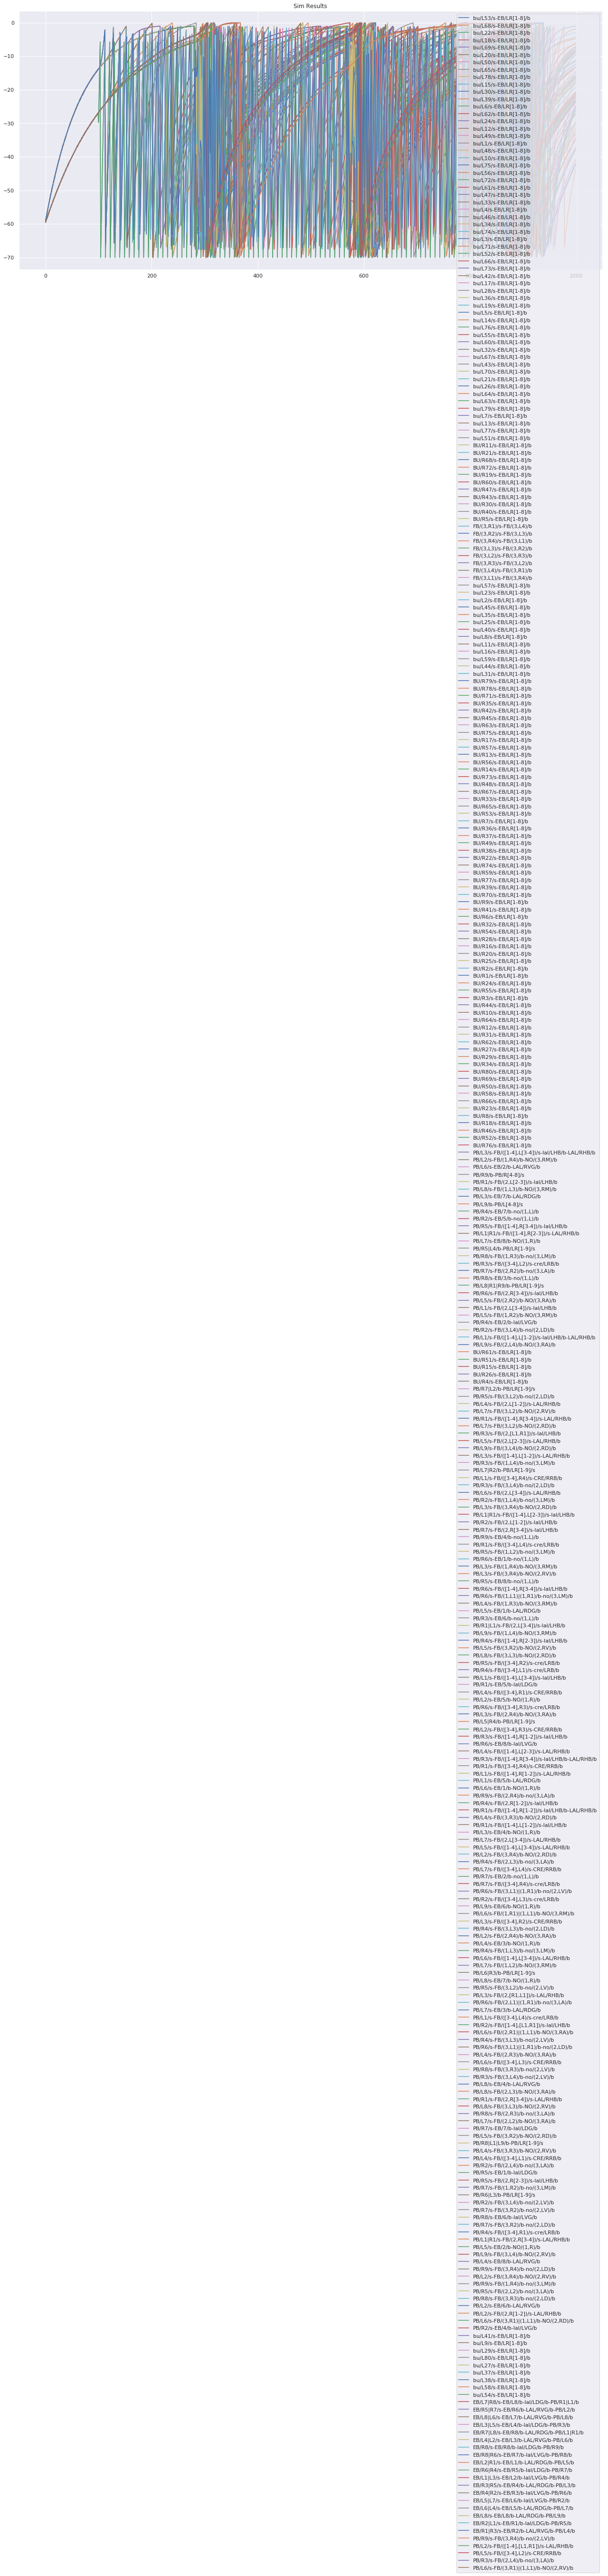

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(22,10))
# plot the voltage trace of the first neuorn receiving input
plt.plot(B.T[:,neurons.index(cx.data.node[uids[0]]['name'])]) 
plt.show()

# plot all neuron responses
plt.figure(figsize=(22,10))
plt.title('Sim Results')
plt.plot(B.T)
plt.legend(neurons)
plt.show()